In [51]:
# Imports
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from collections import namedtuple
from sklearn.metrics import roc_curve, auc

In [2]:
# Load data
train = np.loadtxt('kepler_dataset/exoTrain.csv', delimiter=",", skiprows=1, dtype=np.float32)
test = np.loadtxt('kepler_dataset/exoTest.csv', delimiter=",", skiprows=1, dtype=np.float32)

In [3]:
# Preprocess data

# Normalize all data
train[:,1:] = (train[:,1:] - np.mean(train[:,1:], axis=1).reshape(-1,1) / np.std(train[:,1:], axis=1).reshape(-1,1))
train[:,:1] = train[:,:1] - 1

test[:,1:] = (test[:,1:] - np.mean(test[:,1:], axis=1).reshape(-1,1) / np.std(test[:,1:], axis=1).reshape(-1,1))
test[:,:1] = test[:,:1] - 1

# Augment train data
idx_one = np.where(train[:,:1] == 1)[0]
idx_zero = np.where(train[:,:1] == 0)[0]

for _ in range(len(idx_zero) - len(idx_one)):
    idx_source = np.random.randint(len(idx_one))
    time_shift = np.random.randint(train.shape[1] - 1)
    new_row = np.concatenate((train[idx_source][:1], np.roll(train[idx_source][1:], time_shift)))
    train = np.vstack([train, np.expand_dims(new_row, 0)])
    
# Shuffle train data
np.random.shuffle(train)

# Add dimension
x_train = np.expand_dims(train[:, 1:], axis=2)
x_train = np.concatenate((x_train, uniform_filter1d(x_train, axis=1, size=200)), axis=2)
y_train = np.expand_dims(train[:, 0].astype(np.int32), axis=1)

x_test = np.expand_dims(test[:, 1:], axis=2)
x_test = np.concatenate((x_test, uniform_filter1d(x_test, axis=1, size=200)), axis=2)
y_test = np.expand_dims(test[:, 0].astype(np.int32), axis=1)

In [10]:
# Create Dataset and Iterator
batch_size = 32
tf.reset_default_graph()

# Train dataset
x_train_placeholder = tf.placeholder(x_train.dtype, x_train.shape)
y_train_placeholder = tf.placeholder(y_train.dtype, y_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_placeholder, y_train_placeholder))
train_dataset = train_dataset.batch(batch_size)

# Test dataset
x_test_placeholder = tf.placeholder(x_test.dtype, x_test.shape)
y_test_placeholder = tf.placeholder(y_test.dtype, y_test.shape)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_placeholder, y_test_placeholder))
test_dataset = test_dataset.batch(batch_size)
# Create iterator and its initializers
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
next_batch = iterator.get_next()
train_iter_init_op = {'fetches': iterator.make_initializer(train_dataset), 
                      'feed_dict': {x_train_placeholder: x_train, y_train_placeholder: y_train}}
test_iter_init_op = {'fetches': iterator.make_initializer(test_dataset), 
                     'feed_dict': {x_test_placeholder: x_test, y_test_placeholder: y_test}}

In [11]:
# Build graph
x_batch, y_batch = next_batch
is_train = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32)
threshold = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

conv1_w = tf.get_variable('conv_layer1_weights', shape=[31, 2, 32], initializer=tf.contrib.layers.xavier_initializer())
conv1_b = tf.get_variable('conv_layer1_bias', 32, initializer=tf.constant_initializer(0))

model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(x_batch, conv1_w, stride=1, padding='SAME'), conv1_b))
model_out = tf.nn.max_pool(tf.expand_dims(model_out, axis=1), ksize=[1, 1, 31, 1], strides=[1, 1, 31, 1], padding='VALID')

cell = tf.contrib.rnn.LSTMCell(32)
lstm_input_list = tf.unstack(tf.squeeze(model_out, axis=1), axis=1)
outputs, states = tf.nn.static_rnn(cell, lstm_input_list, dtype=tf.float32)
model_out = outputs[-1]

model_out = tf.contrib.layers.flatten(model_out)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 1, activation_fn=None)

loss = tf.losses.sigmoid_cross_entropy(y_batch, model_out)
training_op = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
prediction = tf.nn.sigmoid(model_out)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.to_int32(tf.greater(prediction, threshold)), y_batch)))

In [39]:
Epoch_Data = namedtuple('Epoch_data', ['loss', 'accuracy', 'predictions', 'run_time'])

def run_epoch(mode, lr=None, thresh=0.5, keep=0.5):
    if mode is 'train':
        iter_init_op = train_iter_init_op
        batch_op = {'fetches': [loss, prediction, accuracy, training_op] + tf.get_collection(tf.GraphKeys.UPDATE_OPS), 
                    'feed_dict': {learning_rate: lr, keep_prob: keep, is_train: True, threshold: thresh}}
        
    elif mode is 'infer':
        iter_init_op = test_iter_init_op
        batch_op = {'fetches': [loss, prediction, accuracy], 
                    'feed_dict': {keep_prob: keep, is_train: False, threshold: thresh}}
        
    start_time = time.time()
    losses = []
    predictions = []
    accs = []
    sess.run(**iter_init_op)
    while True:
        try:
            batch_outputs = sess.run(**batch_op)
            
            losses.append(batch_outputs[0])
            predictions.append(batch_outputs[1])
            accs.append(batch_outputs[2])                
        except tf.errors.OutOfRangeError:
            break
    epoch_time = time.time() - start_time
    
    return Epoch_Data(np.mean(losses), np.mean(accs), predictions, epoch_time)

In [47]:
# Train model
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())
for epoch in range(5):
    train_d = run_epoch('train', lr=0.01, keep=1.0)
    test_d = run_epoch('infer', keep=1.0)
    
    printables = (epoch+1, train_d.run_time+test_d.run_time, train_d.accuracy, train_d.loss, test_d.accuracy)
    print ("Epoch %02i\tDuration: %02is\tTrain accuracy: %.4f\tTrain loss: %.4f\tTest accuracy: %.4f" % printables) 
    

Epoch 01	Duration: 09s	Train accuracy: 0.9962	Train loss: 0.0146	Test accuracy: 0.9896
Epoch 02	Duration: 09s	Train accuracy: 0.9963	Train loss: 0.0141	Test accuracy: 0.9913
Epoch 03	Duration: 09s	Train accuracy: 0.9964	Train loss: 0.0140	Test accuracy: 0.9913
Epoch 04	Duration: 09s	Train accuracy: 0.9964	Train loss: 0.0139	Test accuracy: 0.9931
Epoch 05	Duration: 09s	Train accuracy: 0.9966	Train loss: 0.0138	Test accuracy: 0.9931


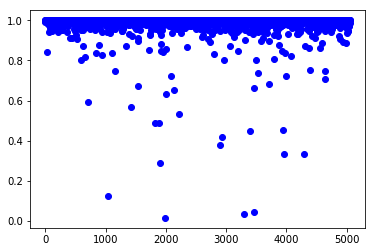

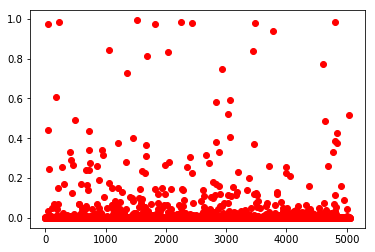

In [49]:
train_d = run_epoch('train', lr=0.0001, keep=1.0)
predictions = np.concatenate(train_d.predictions)
yes_idx = np.where(y_train[:,0] >= 0.5)[0]
non_idx = np.where(y_train[:,0] < 0.5)[0]
plt.plot([predictions[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([predictions[i] for i in non_idx], 'ro')
plt.show()

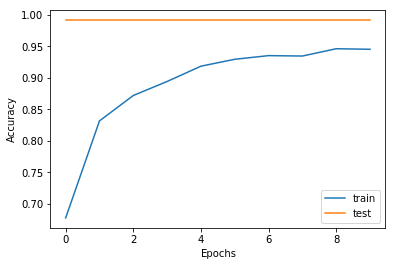

In [7]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train', 'test'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [57]:
non_idx = np.where(predictions[:,0] > 0.94)[0]
fpr, tpr, threshold = roc_curve(y_train, predictions)
print (threshold)

[  9.99968886e-01   9.99924779e-01   9.99923348e-01   9.99901772e-01
   9.99900937e-01   9.99900222e-01   9.99899507e-01   9.99898434e-01
   9.99897361e-01   9.99890327e-01   9.99889135e-01   9.99888778e-01
   9.99887824e-01   9.99887705e-01   9.99887586e-01   9.99881744e-01
   9.99881268e-01   9.99880433e-01   9.99880075e-01   9.99879837e-01
   9.99878645e-01   9.99868274e-01   9.99867797e-01   9.99864101e-01
   9.99863982e-01   9.99863505e-01   9.99863148e-01   9.99857426e-01
   9.99857068e-01   9.99854207e-01   9.99853611e-01   9.99853253e-01
   9.99852538e-01   9.99850273e-01   9.99849796e-01   9.99848247e-01
   9.99847889e-01   9.99847293e-01   9.99847174e-01   9.99846101e-01
   9.99845743e-01   9.99844432e-01   9.99844313e-01   9.99843121e-01
   9.99842763e-01   9.99842167e-01   9.99842048e-01   9.99837279e-01
   9.99837160e-01   9.99830842e-01   9.99830723e-01   9.99830604e-01
   9.99830484e-01   9.99830008e-01   9.99829769e-01   9.99828100e-01
   9.99826729e-01   9.99826491e-01